In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from datetime import date
import itertools
import calendar

In [2]:
df_orig = pd.read_csv('/Users/srosentr 1/Desktop/events_pms_cells_23feb.csv')

/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (77,78,79,80,81,82,83,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [251]:
from datetime import date
import calendar
df_orig['time'] = pd.to_datetime(df_orig['start_time_utc'])
df_orig['time_orig'] = pd.to_datetime(df_orig['start_time'])
df_orig['day'] = df_orig['time_orig'].apply(lambda x: calendar.day_name[x.weekday()]).astype('category')
df_orig['weekend'] = df_orig['day'].apply(lambda x: 'yes' if( (x == 'Saturday') or (x == 'Sunday') ) else 'no' ).astype('category')

## infra functions

In [252]:
def intervalCalcDelta(data_orig, events, func, pm, steps_before=96, steps_after=96,steps_skip=1):
    '''input:
    data: data frame, 
    events: list of events in datetime64 format in numpy array - df['time'].values, 
    func: aggregated function, 
    pm: target pm
    steps before the event, steps after the events, steps skip for the after part..
    output:
    results df with event|before|after'''
    data = data_orig.reset_index()
    results = pd.DataFrame(columns=['event', 'before','after'])
    for event in events:
        event_index = data[data['time'] == event].index.values[0]
        before_event = data.iloc[event_index-steps_before:event_index,:][[pm]].apply(func).values[0]
        after_event = data.iloc[event_index+steps_skip:event_index+steps_skip+steps_after,:][[pm]].apply(func).values[0]
        diff = after_event - before_event
        percent = (after_event - before_event)/before_event
        result = {'event':event, 'before':before_event, 'after':after_event, 'diff': diff, 'percent': percent}
        results = results.append(result, ignore_index=True)
    return results

## Data prep

In [118]:
func_list = [np.mean]
#pm_list = ['cbra_discard_due_cell_range']
#pm_list = ['cbra_discard_due_cell_range','dl_prb_utilization', 'dl_throughput_den', 'active_ue_dl_avg', 'erab_estab_succ_rate_num']
cell_list=df_orig[df_orig['newAttributeValues']=='cellRange']['name'].unique()
pm_list = [u'active_ue_dl_avg', u'active_ue_dl_max', u'active_ue_dl_sum',
       u'active_ue_ul_max', u'active_ue_ul_sum', u'average_rrc_connected',
       u'bad_coverage', u'bad_coverage_rate', u'cbra_discard_due_cell_range',
       u'dl_payload', u'dl_prb_util_den', u'dl_prb_util_num',
       u'dl_prb_utilization', u'dl_throughput_den', u'dl_throughput_num',
       u'dl_ue_throughput_den', u'dl_ue_throughput_num', 
       u'erab_attempts_qci1', u'erab_drops', u'erab_drops_qci1',
       u'erab_est_suc_init', u'erab_estab_succ_rate_den',
       u'erab_estab_succ_rate_num', u'erab_initiated', u'erab_initiated_qci1',
       u'erab_releases', u'erab_releases_qci1', u'erab_releases_qci5', 
       u'intra_ho_att', u'intra_ho_succ', u'irat_redirects', 
       u'lte_cell_downtime_auto', u'lte_cell_downtime_man', u'max_users',
       u'pdcch', u'pdcch_den', u'pdcch_num', u'rach_attempts',
       u'rach_cb_attempts', u'rach_cb_successes', u'rach_successes',
       u'rrc_conn_den', u'rrc_conn_num', u'rrc_connection_failure_rate_den',
       u'rrc_connection_failure_rate_num', u'rrc_estab_att', u'rrc_estab_den',
       u'rrc_estab_reatt', u'rrc_estab_rej', u'rrc_estab_succ',
       u'rrc_estab_succ_rate_den', u'rrc_estab_succ_rate_num',
       u'rrc_succ_rate', u's1_sig_estab_succ_rate_den',
       u's1_sig_estab_succ_rate_num', u'tot_ho_att',
       u'tot_ho_succ', u'ul_iot_samp', u'ul_iot_sum', u'ul_payload',
       u'ul_prb_util_den', u'ul_prb_util_num', u'ul_throughput_den',
       u'ul_throughput_num', u'ul_ue_throughput_den', u'ul_ue_throughput_num',
       u'voip_bearers_den', u'voip_bearers_num', u'x2_ho_success_rate_den',
       u'x2_ho_success_rate_num']

In [ ]:
#the loop to create the basic dataframe towards running the models
df = df_orig[df_orig['newAttributeValues'].notnull()]
pm_results = pd.DataFrame()
for pm in pm_list:
    try:
        cell_results = pd.DataFrame()
        for cell in cell_list:
            cell_df = df_orig[df_orig['name']==cell]
            cell_df_notnull = cell_df[cell_df['newAttributeValues'].notnull()]
            #event_types = cell_df_notnull['newAttributeValues'].unique()
            event_types = ['cellRange']
            event_results = pd.DataFrame()
            for event_type in event_types:
                cell_event_df = cell_df_notnull[cell_df_notnull['newAttributeValues']==event_type]
                event_list = cell_event_df['time'].values
                events_df = cell_event_df[cell_event_df['time'].isin(event_list)][['time', 'value_0']]
                additional_event_data = pd.DataFrame({'pm': pm, 'cell': cell, 'eventName': event_type, 'eventTime': event_list, 'eventValue': events_df['value_0'], 'day': cell_event_df['day'], 'weekend': cell_event_df['weekend']}).reset_index()
                func_results = pd.DataFrame()
                for func in func_list:
                    current_func_results = intervalCalcDelta(cell_df, event_list, func, pm, steps_before=96, steps_after=96,steps_skip=1)
                    current_func_results.columns = ['event', str.split(str(func))[1].capitalize() + 'Before', str.split(str(func))[1].capitalize() + 'After', str.split(str(func))[1].capitalize() + 'Diff', str.split(str(func))[1].capitalize() + 'Percent']
                    func_results = pd.concat([func_results, current_func_results], axis='columns')
                event_results_a = pd.concat([event_results, func_results])
                event_results = pd.concat([additional_event_data, event_results_a], axis='columns')
            cell_results = pd.concat([cell_results, event_results])
        pm_results = pd.concat([pm_results, cell_results])
    except:
        print "failed on ", pm
results_df2 = pm_results.copy()
results_df2.reset_index()
    

failed on  active_ue_dl_max
failed on  active_ue_dl_sum
failed on  active_ue_ul_max
failed on  active_ue_ul_sum
failed on  average_rrc_connected


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [121]:
#genrate the pivot table for the model
df2 = pd.get_dummies(results_df2,columns=['eventName'], prefix='', prefix_sep="")
for column in df2.columns[(len(df2.columns)-1):]:
    df2[column] = df2[df2[column] == 1][['eventValue']]

In [122]:
#add the weekday and weekend as dummies:
df2 = pd.get_dummies(df2, columns=['day', 'weekend'])

In [123]:
#remove inf/nan in targets
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(subset=['MeanDiff', 'MeanPercent'], how="any")

In [124]:
#reset the index
df2 = df2.reset_index()

In [125]:
#fill the nan between events and calculate the diff between the current event value and the previous one
df2['event_after_ffill']=df2.groupby('cell')['eventValue'].fillna(method='ffill')
df2['eventValue_shifted'] = df2.groupby('cell')['event_after_ffill'].apply(lambda x: x.shift(+1))
df2['event_diff']=df2.groupby('cell')['event_after_ffill'].fillna(0).astype(int)-df2.groupby('cell')['eventValue_shifted'].fillna(float('nan')).astype(float)

In [126]:
#remove all the nun events
df2 = df2.dropna(how='any', axis='rows')

In [127]:
#remove outliers in the target - OPTIONAL
percentile_to_keep = .95
df2_outliers = df2[df2['MeanPercent'] < df2['MeanPercent'].quantile(percentile_to_keep)]

In [128]:
#new target: "stepMeanPercent":
# meanDiff > step_Th -> step=1
# meanDiff < -step_Th -> step=-1
#-step_th<meanDiff<step_Th -> step=0

def check_step(x, step_Th=0.15):
    x = x
    if x > step_Th:
        return 1
    elif x < -step_Th:
        return -1
    else:
        return 0    


In [129]:
df2['stepMeanPercent'] = df2['MeanPercent'].apply(check_step)

## 1: Random Forest Classifier on: Features['cellRange' , 'event_diff', 'weekday', 'weekendOrNot']| Target['stepMeanPercent']

In [94]:
features = ['cellRange', 'event_diff',u'day_Friday',
       u'day_Monday', u'day_Saturday', u'day_Sunday', u'day_Thursday',
       u'day_Tuesday', u'day_Wednesday', u'weekend_no', u'weekend_yes']

In [95]:
target = ['stepMeanPercent']

In [96]:
X1 = df2[features]
y1 = df2[target]

In [74]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)

In [75]:
RF1 = RandomForestClassifier(random_state=0, n_estimators=100, verbose=1)
RF1.fit(X_train1,y_train1)
y_pred1 = RF1.predict(X_test1)
y_pred1 = y_pred1.reshape(-1,1)
print(str.format( 'Train score: {}', RF1.score(X_train1, y_train1)) )
print(str.format( 'Test score: {}',  RF1.score(X_test1, y_test1)) )
feature_importance = RF1.feature_importances_
print('\nfeature importance:')
for i in range(0,len(features)):
    print features[i], feature_importance[i]
prediction1 = pd.DataFrame.copy(y_test1)
prediction1['stepMeanPercent_predict'] = y_pred1


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train score: 0.83064516129
Test score: 0.790322580645

feature importance:
cellRange 0.5373433110102804
event_diff 0.30096563444820124
day_Friday 0.03295759416511813
day_Monday 0.03008987598984332
day_Saturday 0.0
day_Sunday 0.0019180387141851897
day_Thursday 0.03813002803482767
day_Tuesday 0.039357569734941054
day_Wednesday 0.015197291489895208
weekend_no 0.002673744191350213
weekend_yes 0.001366912221357456


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


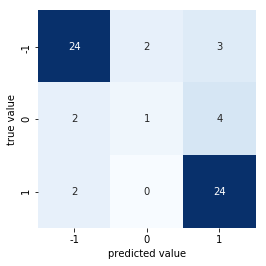

In [76]:
# confusion matrix
mat = confusion_matrix(prediction1['stepMeanPercent'], prediction1['stepMeanPercent_predict'])

sns.heatmap(mat, square=True, annot=True, cbar=False, xticklabels=[-1,0,1], yticklabels=[-1,0,1], cmap="Blues")
plt.xlabel('predicted value')
plt.ylabel('true value');

In [77]:
# precision , Recall:
p,r,f,s = precision_recall_fscore_support(prediction1['stepMeanPercent'], prediction1['stepMeanPercent_predict'])
class_results1 = pd.DataFrame({'precision': p, 'recall': r, 'support': s})
class_results1.index = ['-1', '0', '1']
class_results1

,precision,recall,support
-1,0.857143,0.827586,29
0,0.333333,0.142857,7
1,0.774194,0.923077,26


In [104]:
df2['pm'].unique()[1]

'dl_prb_utilization'

In [102]:
# loop on pms correlation for cellRange

In [241]:
results = pd.DataFrame()
for pm in df2['pm'].unique():
    try:
        print str.format('\nEvent: cellRange, PM: {}\n', pm)
        df2_pm = df2[df2['pm']==pm]
        X1 = df2_pm[features]
        y1 = df2_pm[target]
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)
        RF1 = RandomForestClassifier(random_state=0, n_estimators=100)
        RF1.fit(X_train1,y_train1)
        y_pred1 = RF1.predict(X_test1)
        y_pred1 = y_pred1.reshape(-1,1)
        score = RF1.score(X_test1, y_test1)
        #print(str.format( 'Train score: {}', RF1.score(X_train1, y_train1)) )
        #print(str.format( '**Test score: {}',  score) )
        #feature_importance = RF1.feature_importances_
        #print('\nfeature importance:')
        #for i in range(0,len(features)):
        #    print features[i], feature_importance[i]
        prediction1 = pd.DataFrame.copy(y_test1)
        prediction1['stepMeanPercent_predict'] = y_pred1
        # precision , Recall:
        p,r,f,s = precision_recall_fscore_support(prediction1['stepMeanPercent'], prediction1['stepMeanPercent_predict'])
        class_results1 = pd.DataFrame({'precision': p, 'recall': r, 'support': s})
        class_results1.index = ['-1', '0', '1']
        results = pd.concat([results, pd.DataFrame( {'pm': pm, 'score': score, 'F_minus1': f[0], 'S_minus1': s[0], 'F_noStep': f[1], 'S_noStep': s[1], 'F_plus1': f[2], 'S_plus1': s[2]}, index=range(1) )])
    except:
        print "failure", pm
results = results.reset_index()


Event: cellRange, PM: active_ue_dl_avg



/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.



Event: cellRange, PM: active_ue_dl_max


Event: cellRange, PM: active_ue_dl_sum


Event: cellRange, PM: active_ue_ul_max


Event: cellRange, PM: active_ue_ul_sum


Event: cellRange, PM: average_rrc_connected


Event: cellRange, PM: bad_coverage


Event: cellRange, PM: bad_coverage_rate


Event: cellRange, PM: cbra_discard_due_cell_range


Event: cellRange, PM: dl_payload


Event: cellRange, PM: dl_prb_util_den

failure dl_prb_util_den

Event: cellRange, PM: dl_prb_util_num


Event: cellRange, PM: dl_prb_utilization


Event: cellRange, PM: dl_throughput_den


Event: cellRange, PM: dl_throughput_num


Event: cellRange, PM: dl_ue_throughput_den


Event: cellRange, PM: dl_ue_throughput_num


Event: cellRange, PM: erab_attempts_qci1


Event: cellRange, PM: erab_drops


Event: cellRange, PM: erab_drops_qci1


Event: cellRange, PM: erab_est_suc_init


Event: cellRange, PM: erab_estab_succ_rate_den


Event: cellRange, PM: erab_estab_succ_rate_num


Event: cellRange, PM: erab_initiated


Event

In [249]:
def highlight_max(s):
    is_max = s == s.max()
    return ['color: blue' if v else '' for v in is_max]

del results['index']

results = results.style.apply(lambda x: ["color: blue" if v > 0.5  else "" for v in x], axis=1, subset=['score']).apply(highlight_max, subset=['F_minus1', 'F_plus1', 'F_noStep'], axis=1)            

TypeError: 'Styler' object does not support item deletion

In [248]:
results

,F_minus1,F_noStep,F_plus1,S_minus1,S_noStep,S_plus1,pm,score
0,0,0.882883,0,7,52,3,active_ue_dl_avg,0.790323
1,0,0.79803,0.222222,14,94,17,active_ue_dl_max,0.672
2,0.278481,0.285714,0.404255,33,52,40,active_ue_dl_sum,0.328
3,0,0.84507,0.0740741,6,99,20,active_ue_ul_max,0.728
4,0.25641,0.597222,0.268657,26,70,29,active_ue_ul_sum,0.456
5,0.378378,0.682927,0.285714,21,84,20,average_rrc_connected,0.56
6,0.387097,0.25,0.407767,39,19,60,bad_coverage,0.372881
7,0.363636,0.232558,0.438095,41,21,56,bad_coverage_rate,0.372881
8,0.692308,0.117647,0.744186,56,15,54,cbra_discard_due_cell_range,0.68
9,0.257143,0.403846,0.263158,29,58,38,dl_payload,0.32


In [246]:
results[(results['score']<0.5)&(results['score']>0.3)&(results['F_noStep']<0.4)]

,index,F_minus1,F_noStep,F_plus1,S_minus1,S_noStep,S_plus1,pm,score
2,0,0.278481,0.285714,0.404255,33,52,40,active_ue_dl_sum,0.328000
6,0,0.387097,0.250000,0.407767,39,19,60,bad_coverage,0.372881
7,0,0.363636,0.232558,0.438095,41,21,56,bad_coverage_rate,0.372881
14,0,0.352941,0.218750,0.435644,38,40,47,dl_ue_throughput_den,0.352000
17,0,0.233333,0.395349,0.520000,36,43,44,erab_drops,0.406504
18,0,0.511628,0.125000,0.277778,36,23,18,erab_drops_qci1,0.376623
29,0,0.482759,0.375000,0.322581,14,5,19,irat_redirects,0.394737
33,0,0.320000,0.279070,0.426966,37,47,41,rach_attempts,0.344000
34,0,0.320000,0.279070,0.426966,37,47,41,rach_cb_attempts,0.344000
42,0,0.459770,0.150000,0.513274,44,25,51,rrc_estab_reatt,0.433333
